In [1]:
#import sys
#!{sys.executable} -m pip install nltk
#!{sys.executable} -m pip install yellowbrick

In [2]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import re

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB

# Under-sampling imports from imblearn
from imblearn.under_sampling import RandomUnderSampler

# scipy sparse matrix
import scipy
from scipy.sparse import hstack

import matplotlib.pyplot as plt

import os

## Data Preprocessing

In [3]:
def cleanup_URL(s):
    s = s if s else ''

    try:
        tokens = filter(lambda x: x != '', re.split(r'\W', s))    
        
        # remove common substrings
        tokens = filter(lambda x: x != 'http' , tokens)
        tokens = filter(lambda x: x != 'www' , tokens)
        
        tokens = filter(lambda x: x != 'com' , tokens)
        
        tokens = filter(lambda x: x != 'index' , tokens)
        tokens = filter(lambda x: x != 'html' , tokens)
        tokens = filter(lambda x: x != 'htm' , tokens)
        
        # tokens = filter(lambda x: x != 'co' , tokens)
        # tokens = filter(lambda x: x != 'uk' , tokens)
        # tokens = filter(lambda x: x != 'org' , tokens)
        # tokens = filter(lambda x: x != 'net' , tokens)
        
        # remove digits
        # tokens = map(lambda x: re.sub(r'[0-9]+', '', x), tokens)
        
        tokens = list(tokens)

    except Exception as e:
        tokens = []

    return ''.join(tokens)


def parse_dataset(df):
    df['path'] = list(map(cleanup_URL, df['url']))

    return df

In [4]:
df = pd.read_csv('../../URL_Classification.csv', header=None)
df.columns = ["index", "url", "label"]

num_samples = len(df)
df = df[0:num_samples]

In [5]:
print(f"Parsing {len(df)} rows dataset...")
df = parse_dataset(df)

print("Done")

Parsing 1562978 rows dataset...
Done


In [6]:
df.head(15)

,index,url,label,path
0,1,http://www.liquidgeneration.com/,Adult,liquidgeneration
1,2,http://www.onlineanime.org/,Adult,onlineanimeorg
2,3,http://www.ceres.dti.ne.jp/~nekoi/senno/senfir...,Adult,ceresdtinejpnekoisennosenfirst
3,4,http://www.galeon.com/kmh/,Adult,galeonkmh
4,5,http://www.fanworkrecs.com/,Adult,fanworkrecs
5,6,http://www.animehouse.com/,Adult,animehouse
6,7,http://www2.117.ne.jp/~mb1996ax/enadc.html,Adult,www2117nejpmb1996axenadc
7,8,http://archive.rhps.org/fritters/yui/index.html,Adult,archiverhpsorgfrittersyui
8,9,http://www.freecartoonsex.com/,Adult,freecartoonsex
9,10,http://www.cutepet.org/,Adult,cutepetorg


## Dealing with label

Labels are not integer, so we need to transform it.

The original notebook only classified adult content against the rest. We try to distinguish all classes.

In [7]:
unique_labels = list(set(df['label']))
unique_labels.sort()

label2idx = {unique_labels[k] : k for k in range(len(unique_labels))}
idx2label = {i: k for k, i in label2idx.items()}

df['label'] = df['label'].map(label2idx)

In [8]:
label2idx

{'Adult': 0,
 'Arts': 1,
 'Business': 2,
 'Computers': 3,
 'Games': 4,
 'Health': 5,
 'Home': 6,
 'Kids': 7,
 'News': 8,
 'Recreation': 9,
 'Reference': 10,
 'Science': 11,
 'Shopping': 12,
 'Society': 13,
 'Sports': 14}

## Bag of Words

In [9]:
bow_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(5, 5))

X = bow_vectorizer.fit_transform(df['path'])
y = df['label'].values

X, y = shuffle(X, y, random_state=67)

X.shape, y.shape

((1562978, 2424461), (1562978,))

### Under-sample the dataset

We manually undersample the categories of Arts, Society and Business, as those make up the majority
of the dataset and skew our simple model towards them.

Original values were optained using: 

```
awk -F "\"*,\"*" '{print $3}' <CSV-FILE> | grep <CATEGORY> | wc -l
```


In [10]:
# note that this manual description requires the numeric labels to be fixed, as it's done in 'In [7]'.
sample_number = {
    0: 35325,
    1: 117960, # was 253840
    2: 117960, # was 240177
    3: 117962,
    4: 56477,
    5: 60097,
    6: 28269,
    7: 46182,
    8: 8989,
    9: 106586,
    10: 58247,
    11: 110286,
    12: 95270,
    13: 117960, # was 243943
    14: 101328
}

rus = RandomUnderSampler(sampling_strategy=sample_number)
X_resampled, y_resampled = rus.fit_resample(X, y)

## Use Naive Bayes

In [11]:
clf = sklearn.naive_bayes.MultinomialNB()

### Split train/test set to evaluate result

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled,
                                                    y_resampled,
                                                    test_size=0.33,
                                                    random_state=123456)

In [13]:
clf.fit(X_train, y_train)

MultinomialNB()

In [14]:
print(classification_report(y_train, clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.93      0.71      0.81     23583
           1       0.65      0.79      0.71     79041
           2       0.68      0.72      0.70     78760
           3       0.73      0.75      0.74     79276
           4       0.79      0.71      0.74     37802
           5       0.83      0.66      0.73     40286
           6       0.91      0.57      0.70     19093
           7       0.85      0.48      0.61     31093
           8       0.90      0.19      0.32      6069
           9       0.64      0.79      0.71     71185
          10       0.74      0.66      0.70     38849
          11       0.72      0.73      0.73     73649
          12       0.68      0.67      0.68     63971
          13       0.68      0.75      0.72     79165
          14       0.80      0.80      0.80     68039

    accuracy                           0.72    789861
   macro avg       0.77      0.66      0.69    789861
weighted avg       0.73   

In [15]:
y_pred = clf.predict(X_test)

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.58      0.68     11742
           1       0.49      0.60      0.54     38919
           2       0.45      0.49      0.47     39200
           3       0.56      0.57      0.56     38686
           4       0.70      0.59      0.64     18675
           5       0.68      0.50      0.58     19811
           6       0.81      0.47      0.59      9176
           7       0.60      0.30      0.40     15089
           8       0.66      0.11      0.18      2920
           9       0.46      0.58      0.51     35401
          10       0.60      0.53      0.56     19398
          11       0.58      0.59      0.59     36637
          12       0.46      0.46      0.46     31299
          13       0.51      0.58      0.54     38795
          14       0.69      0.66      0.67     33289

    accuracy                           0.55    389037
   macro avg       0.60      0.51      0.53    389037
weighted avg       0.56   

normalize true / rows


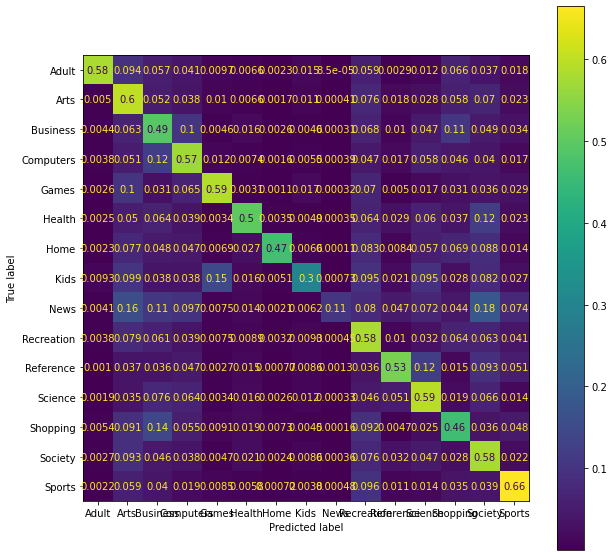

normalize pred / cols


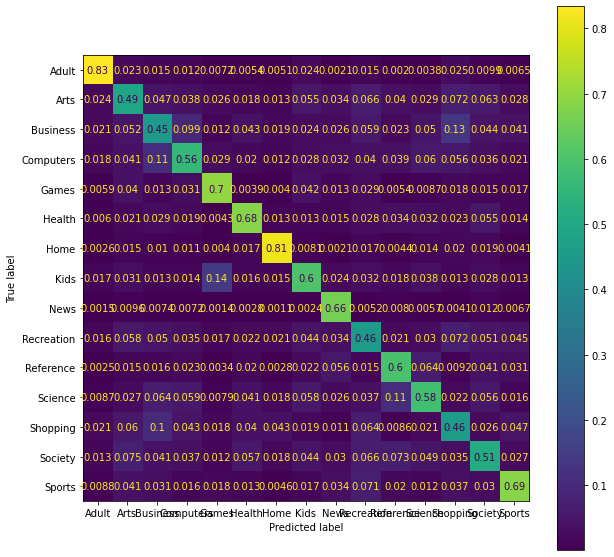

normalize all / cols + rows


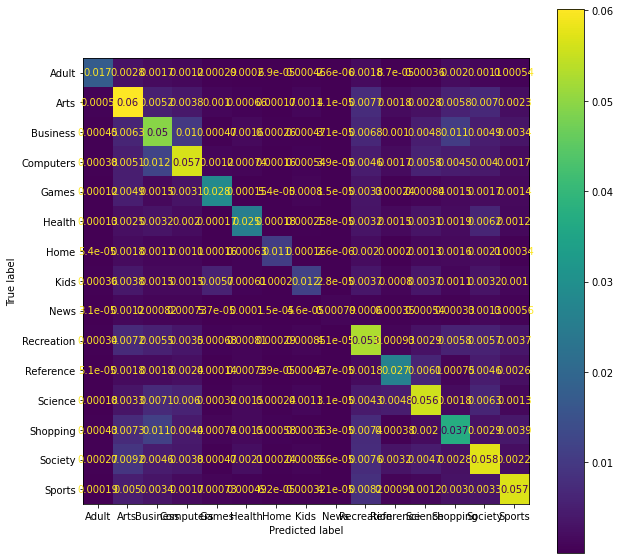

do not normalize


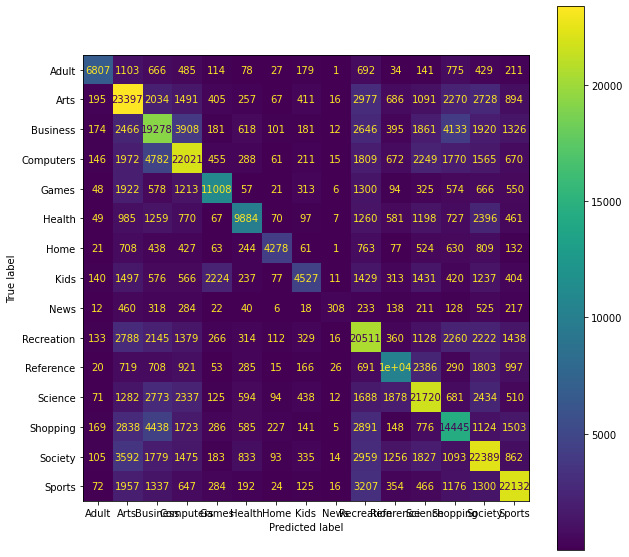

In [17]:
cm_true = confusion_matrix(y_test, y_pred, normalize='true', labels=[k for k in idx2label]) 
cm_pred = confusion_matrix(y_test, y_pred, normalize='pred', labels=[k for k in idx2label])
cm_all = confusion_matrix(y_test, y_pred, normalize='all', labels=[k for k in idx2label])
cm_none = confusion_matrix(y_test, y_pred, labels=[k for k in idx2label])

disp_true = ConfusionMatrixDisplay(confusion_matrix=cm_true, display_labels=unique_labels)
disp_pred = ConfusionMatrixDisplay(confusion_matrix=cm_pred, display_labels=unique_labels)
disp_all = ConfusionMatrixDisplay(confusion_matrix=cm_all, display_labels=unique_labels)
disp_none = ConfusionMatrixDisplay(confusion_matrix=cm_none, display_labels=unique_labels)

plt.rc('font', size=24)

fig, ax = plt.subplots(figsize=(10, 10))
print('normalize true / rows')
disp_true.plot(include_values=True, ax=ax)
plt.show()

fig, bx = plt.subplots(figsize=(10, 10))
print('normalize pred / cols')
disp_pred.plot(include_values=True, ax=bx)
plt.show()

fig, cx = plt.subplots(figsize=(10, 10))
print('normalize all / cols + rows')
disp_all.plot(include_values=True, ax=cx)
plt.show()

fig, dx = plt.subplots(figsize=(10, 10))
print('do not normalize')
disp_none.plot(include_values=True, ax=dx)
plt.show()

### Cross Validation

In [18]:
cvs = cross_val_score(clf, X_resampled, y_resampled, cv=3, scoring='f1_macro')
print(f'Mean {np.mean(cvs):.5f} \tVar {np.var(cvs):.5f}')

Mean 0.53117 	Var 0.00000
